In [ ]:
# !pip install import-ipynb
# import import_ipynb

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/Coursework/24789 EE Project/Slade Preprocessing"

/content/drive/.shortcut-targets-by-id/1m8vZXGAmuF90_TYMyJT9xg1YSt_opouY/24789 EE Project/Slade Preprocessing


In [2]:
import sys
from glob import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.signal import filtfilt, butter
from scipy import signal
from numpy import genfromtxt
from natsort import natsorted
import os
from shutil import copy
import csv
import datetime
import pytz
cwd = os.getcwd()

def loadTrueMetInterp(met_ss_interp):
    num_subjs = met_ss_interp.shape[0]
    tv_mat = np.zeros((num_subjs, 4,30))
    del_list = []
    # make a list of each condition with non-zero vals and append them all then take the mean of that
    
    for i in range(num_subjs):
        met_ss_interp_avg = met_ss_interp[i,:]#np.mean(met_ss_interp,axis=0) # should be just size 5 for standing, walk, run
        if met_ss_interp[i,-1] != 0.0:
            del_list.append(i)
        met_ss_speeds = np.array([0.,1.,1.5,2.5,3.])
        tv1_sp = np.array([0.0, 0.0, 1.0, 1.0, 0.0])
        tv1_t = np.array([0., 4., 6., 16., 18.])
        tv1_int = np.arange(0,24)
        tv1_true_sp = np.interp(tv1_int,tv1_t,tv1_sp)
        tv1_true_met = np.interp(tv1_true_sp, met_ss_speeds, met_ss_interp_avg)

        tv4_sp = np.array([1.0, 1.0, 3.0, 3.0, 1.0])
        tv4_t = np.array([0., 6., 10., 22., 26.])
        tv_int = np.arange(0,30)
        tv4_true_sp = np.interp(tv_int,tv4_t,tv4_sp)
        tv4_true_met = np.interp(tv4_true_sp, met_ss_speeds, met_ss_interp_avg)  

        p = 30.0
        t = np.linspace(0,29,30)
        min_speed = 1.0
        max_speed = 1.5
        avg = (min_speed + max_speed)/2.0
        ampl = (max_speed - min_speed)/2.0
        tv_sine = avg + ampl*np.sin(2*3.14159*(t-p/4-6)/p)
        tv2_true_met = np.interp(tv_sine, met_ss_speeds, met_ss_interp_avg)

        min_speed = 1.0
        max_speed = 3.00
        avg = (min_speed + max_speed)/2.0
        ampl = (max_speed - min_speed)/2.0
        tv_sine = avg + ampl*np.sin(2*3.14159*(t-p/4-6)/p)
        tv3_true_met = np.interp(tv_sine, met_ss_speeds, met_ss_interp_avg)

        tv_mat[i,0,:24] = tv1_true_met
        tv_mat[i,1,:] = tv2_true_met
        tv_mat[i,3,:] = tv3_true_met
        tv_mat[i,2,:] = tv4_true_met
    
    tv_avg_mat = np.zeros((4,30))
    true_inds = np.zeros((4, num_subjs))
    for j in range(4):
        if j >= 2:
            tv_avg_mat[j,:] = np.mean(tv_mat[del_list,j,:],axis=0)
            true_inds[j,del_list] = 1

        else:
            tv_avg_mat[j,:] = np.mean(tv_mat[:,j,:], axis=0)
            true_inds[j,:] = 1
            
    return tv_mat, tv_avg_mat, true_inds

# def loadRawMet(data_dir, subj, timezone):
#     gen_files = os.listdir(data_dir+subj)
#     for filename in gen_files:
#         if len(filename) >= 4:
#             if filename[-4:] == 'xlsx': # metabolics file
#                 met_array = pd.read_excel(data_dir+subj+'/'+filename, names=["time","V02","VC02","HR"], skiprows=3, usecols=[9, 14, 15, 23]) # left then right insole forces   
#                 met_array['MET'] = (met_array["V02"]*16.48 + met_array["VC02"]*4.48)/60.
#                 dt = [i.hour*3600 + i.minute*60 + i.second for i in met_array["time"]]

#                 # load starting time
#                 met_raw = np.array(pd.read_excel(data_dir+subj+'/'+filename, usecols=[4], header=None))
#                 starting_time = met_raw[0:2]
#                 test = str(starting_time[0][0]) + ' ' + str(starting_time[1][0])
#                 test_dt = datetime.datetime.strptime(test, '%m/%d/%Y %I:%M:%S %p')  
#                 test_dt = timezone.localize(test_dt)
#                 time_stamps = [test_dt + datetime.timedelta(seconds=i) for i in dt]
#                 met_array["time_stamp"] = time_stamps
#                 met_array["dt"] = np.array(dt) - dt[0] 
                
#     return met_array, time_stamps

# gets all data between start and stop time 
def getCondData(input_data, time_stamps, start_time, cond_len, time_stamp_label='time_stamp', tz = "America/Los_Angeles"):
    stop_time = start_time + datetime.timedelta(seconds=cond_len)
    mask = (input_data[time_stamp_label] > start_time) & (input_data[time_stamp_label] < stop_time)
    try:
        last_true_ind = mask.index[mask][-1]
        mask[last_true_ind+1] = True
    except:
        print("Error adding last index beyond the end of the file")
    input_subset = input_data.loc[mask]
    first_true_ind = mask.index[mask][0]
    input_subset["dt"] = np.array(input_subset["dt"]) - np.array(input_subset["dt"])[0] + (time_stamps[first_true_ind] - start_time).total_seconds()
    return input_subset


def watchValidationPlot(ee_interp, hr_interp, ee_met, hr, dd):
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Energy expenditure (W)')
    ax1.plot(np.arange(len(ee_met)), ee_met, color='k', alpha=0.7, label='Respirometry per breath')
    ax1.plot(np.arange(len(dd)), dd, color='b', label='Data driven')
    ax1.legend(loc='lower right')
    fig.tight_layout()
    plt.show()

# takes in input data in [time steps x feats] and computes heel strikes over sliding window
# returns processed matrix of processed gait cycles, stacked [gaits x binned feats]
def simRealStrikes(input_data, weight, height, shift_ind, stride_detect_window, detect_window, peak_height_thresh, peak_min_dist, shank_gyro_z_ind, b, a, deg2rad, old_data = False, data_rate = 100.0, addTime = False):
    gait_data = []
    t_steps, feats = input_data.shape
    watching_heelstrike = True
    watch_strike_cnt = 0 
    time_list = []
    time_of_gait = []
    for k in range(t_steps - stride_detect_window):
        stride_window = input_data[k:k+stride_detect_window]
        if watching_heelstrike: # if looking for heelstrike
            peak_list = checkPeaks(stride_window[:,shank_gyro_z_ind], b, a, peak_height_thresh, peak_min_dist, deg2rad, old_data) # check for peaks
            if len(peak_list) > 1: # checking if a new heel strike has occured
                if (stride_detect_window - peak_list[-1]) < detect_window: # peak has occured in last detect_window of data
                    watching_heelstrike = False # now wait a bit to detect heelstrikes again
                    new_gait_cycle = processRawGait(stride_window, peak_list[-2], peak_list[-1], shift_ind, b, a, weight, height, deg2rad, old_data, data_rate, addTime) # process most recent gait data
                    new_gait_cycle = np.expand_dims(new_gait_cycle, axis=0)
                    time_list.append(peak_list[-1] - peak_list[-2])
                    time_of_gait.append((k + peak_list[-1])/data_rate)
                    if len(gait_data) == 0:
                        gait_data = new_gait_cycle
                    else:
                        gait_data = np.concatenate((gait_data, new_gait_cycle), axis=0)
        else: # count until the peak has cleared the recent window
            if watch_strike_cnt > detect_window:
                watching_heelstrike = True
                watch_strike_cnt = 0
            else:
                watch_strike_cnt += 1        
    return gait_data, time_list, time_of_gait

# compute data-driven estimates interpolated at 1-second intervals
def computeDDinter(real_time_est, est_col_ind, subj, cond, subj_cond_dir, estimate_file_name, timezone, loc_cond_timestamp, cond_time_s, basal_flag=False, basal_rate = 0.0):
    basal_t_thresh = 8.0 # number of second gap between gait cycles to estimate adjusted standing rate
    subjcond_time = []
    subjcond_dt = []
    subjcond_est = []
    with open(subj_cond_dir+estimate_file_name, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        try:
            for row in reader:
                if len(row[1]) == 25:
                    new_dt = timezone.localize(datetime.datetime.strptime(row[1][:-6],"%Y-%m-%d %H:%M:%S"))
                elif len(row[1]) == 26:
                    new_dt = timezone.localize(datetime.datetime.strptime(row[1][:-7],"%Y-%m-%d %H:%M:%S"))
                else:
                    new_dt = timezone.localize(datetime.datetime.strptime(row[1][:-13],"%Y-%m-%d %H:%M:%S"))
 
                subjcond_time.append(float(row[0]))
                subjcond_dt.append(new_dt)
                subjcond_est.append(float(row[est_col_ind]))
        except:
            pass
    f.close()
    # compute time difference between start datetime and first gait cycle
    time_diff = (loc_cond_timestamp - subjcond_dt[0]).total_seconds()
    # from time vector subjtract initial gait value and time difference
    subjcond_time = np.array(subjcond_time)
    subjcond_est = np.array(subjcond_est)
    subjcond_time = subjcond_time - (time_diff + subjcond_time[0])
    # find indeces of gaits occuring after the start of the condition (time == 0) and less than end of condition (time == 300)
    prev_gaits = subjcond_time >= 0.0
    subjcond_time = subjcond_time[prev_gaits]
    subjcond_est = subjcond_est[prev_gaits]
    prev_gaits2 = subjcond_time < cond_time_s
    subjcond_time = subjcond_time[prev_gaits2]
    subjcond_est = subjcond_est[prev_gaits2]
    tmin = 0
    tmax = cond_time_s
    t = np.arange(tmin,tmax)
    dd_int = np.interp(t, subjcond_time, subjcond_est)
    return dd_int, subjcond_est, subjcond_time
    
# take in shank IMU vector, filter, look for thresholding & min_distance, return strike indeces
def checkPeaks(strike_vec, b, a, peak_height_thresh, peak_min_dist, deg2rad, old_data = False):
    if old_data:
        strike_vec_filt = signal.filtfilt(b,a,strike_vec*(-1.0/deg2rad))
    else:
        strike_vec_filt = signal.filtfilt(b,a,strike_vec)
    peak_list = signal.find_peaks(strike_vec_filt, height=peak_height_thresh, distance=peak_min_dist)
    return peak_list[0]
    
# takes data and moves the first half of the data to the second half
# assumes data_array is size [time steps x feature]
def convertBetweenLegs(data_array):
    array_copy = np.copy(data_array)
    convert_array = np.zeros(data_array.shape)
    gait_time_steps,_ = data_array.shape
    half_gait = int(gait_time_steps/2)
    convert_array[:half_gait,:] = array_copy[half_gait:,:]
    convert_array[half_gait:,:] = array_copy[:half_gait,:]
    return convert_array
    
# downsample the data into a discrete number of bins
def binData(data_array, num_bins=30):
    return signal.resample(data_array, num_bins) # resamples along axis = 0 by default

# shift the data in the binned matrix to the left by the given shift_ind
def shiftBinData(data_array, shift_ind, num_bins=30):
    array_copy = np.copy(data_array)
    convert_array = np.zeros(data_array.shape)
    convert_array[:-shift_ind, :] = array_copy[shift_ind:,:]
    convert_array[-shift_ind:, :] = array_copy[:shift_ind,:]
    return convert_array

# pass in array of data to process [time_samples x num_features] into [num_bins x num_features]
# start_ind, end_ind are indeces of start/end of gait cycle
# shift_ind is correction term for timing diff between heel strike and IMU thresh
# b, a are filter parameters
def processRawGait(data_array, start_ind, end_ind, shift_ind, b, a, weight, height, deg2rad, old_data = False, num_bins=30, addTime = False):
    gait_data = data_array[start_ind:end_ind, :] # crop to the gait cycle
    if not old_data:
        gait_data = gait_data*np.array([deg2rad,-deg2rad,-deg2rad,deg2rad,-deg2rad,-deg2rad,1,-1,-1,1,-1,-1]) # flip y & z, convert to rad/s
    filt_gait_data = signal.filtfilt(b,a,gait_data, axis=0) # low-pass filter
    bin_gait = binData(filt_gait_data) # discretize data into bins
    shift_flip_bin_gait = bin_gait.transpose() # get in shape of [feats x bins] for correct flattening
    model_input = shift_flip_bin_gait.flatten()
    if addTime:
        model_input = np.insert(model_input, 0, [weight, height, (end_ind-start_ind)*0.01]) # adding a 1 for the bias term at start
    else:
        model_input = np.insert(model_input, 0, [weight, height]) # adding a 1 for the bias term at start
    return model_input


def mapd(vec1, vec2): # mean absolute percent difference
    return np.abs(vec1 - vec2) / ((vec1 + vec2)/2)

def compute_2min_met_errors(metabolics_real, met_2min_est):
    mae_mat = (np.abs(metabolics_real-met_2min_est)/metabolics_real)
    met_mape = np.mean(mae_mat)
    
    subjs_acc = np.zeros(metabolics_real.shape[0])
    for i in range(metabolics_real.shape[0]): # loop thru subjects
        correct, correct, pairwise_len = pairwise_similarity(metabolics_real[i,:], met_2min_est[i,:])
        subjs_acc[i] = correct/pairwise_len        
        
    ordering = np.mean(subjs_acc)
    return met_mape, ordering

def metabolic_rate_estimation(t, y_meas, tau=42):
    n_samp = len(t)
    A = np.zeros((n_samp,2))
    A[0,:] = [1,0]
    for i in range(1,n_samp):
        for j in range(2):
            dt = t[i] - t[i-1]
            if j == 0:
                A[i,j] = A[i-1,j]*(1-dt/tau)
            else:
                A[i,j] = A[i-1,j]*(1-dt/tau) + (dt/tau)
    x_star = np.dot(np.linalg.pinv(A),y_meas)
    y_bar = np.dot(A,x_star)
    mean_squared_err = np.dot(np.transpose(y_bar-y_meas),(y_bar-y_meas))/n_samp
    met_est = x_star[1]
    
    return met_est, y_bar, mean_squared_err

# pull metabolics from the metabolics .csv file and the subject height/weight from the other .csv
def calc_metabolics2(data_dir, subj, visualize = False, add_heartrate = False, cond_len=14, len_cond_s = 300, end_time_len = 180):
    gen_files = os.listdir(data_dir+subj)
    t_mat = []
    met_mat = []
    hr_mat = []
    for filename in gen_files:
        if len(filename) >= 4:
            if filename[-4:] == 'xlsx': # metabolics file
                if add_heartrate:
                    met_array = np.array(pd.read_excel(data_dir+subj+'/'+filename, skiprows=3, usecols=[9, 14, 15, 23, 35])) # left then right insole forces          
                else:
                    met_array = np.array(pd.read_excel(data_dir+subj+'/'+filename, skiprows=3, usecols=[9, 14, 15, 35])) # left then right insole forces        
                # load starting time
                met_raw = np.array(pd.read_excel(data_dir+subj+'/'+filename, usecols=[4], header=None))
                starting_time = met_raw[0:2]
                test = str(starting_time[0][0]) + ' ' + str(starting_time[1][0])
                test_dt = datetime.datetime.strptime(test, '%m/%d/%Y %I:%M:%S %p')    
                met_len, cols = met_array.shape
                cond_indeces = list(np.arange(1,cond_len+1))
                start_inds = ['start 01','start 02','start 03','start 04','start 05','start 06','start 07','start 08','start 09','start 10','start 11','start 12','start 13', 'start 14', 'start 15', 'start 16']
                start_inds = start_inds[:cond_len]
                hr_int_mat = np.zeros((cond_len, len_cond_s))
                met_int_mat = np.zeros((cond_len, len_cond_s))
                start_stamps = []
                met_inds = []
                met_start_inds = np.zeros(cond_len, dtype=int)
                hr = np.zeros(cond_len) # first value in each col is length to use of this placeholder vector
                met_2mins = np.zeros(cond_len)
                met_vals = np.zeros((cond_len,1))
                for cnd in range(cond_len): # adding to check for conditions out of order
                    for i in range(met_len):
                        if met_array[i,-1] == cond_indeces[cnd]:
                            met_inds.append(i)
                            break
                        if met_array[i,-1] == start_inds[cnd]:
                            start_ind = start_inds.index(met_array[i,-1])
                            met_start_inds[start_ind] = i
                    if i == met_len-1: # didn't find the condition
                        met_inds.append(-1)
                        met_start_inds[len(met_inds)-1] = -1
                        
                # take the average of vco2 and vo2 over the num of avg_breaths, then find W from met eq
                for i, ind in enumerate(met_inds):
                    if ind != -1: # there exists this conditions for this subject
                        end_time = met_array[ind,0]
                        start_ind = ind
                        start_time = end_time

                        while (start_time.hour*3600 + start_time.minute*60 + start_time.second + end_time_len) > (end_time.hour*3600 + end_time.minute*60 + end_time.second):
                            start_ind -= 1 # decrement
                            start_time = met_array[start_ind,0]                    
                        vo2 = np.mean(met_array[start_ind:ind,1])
                        vco2 = np.mean(met_array[start_ind:ind,2])
                        met_vals[i] = (vo2*16.48 + vco2*4.48)/60.0 # BROCKWAY

                        if add_heartrate: # store values in the hr
                            hr[i] = np.mean(met_array[start_ind:ind,-2])
                        
                for i, ind in enumerate(met_start_inds):
                    if ind != -1: # there exists this conditions for this subject
                        start_time = met_array[ind,0]
                        end_time = start_time
                        end_ind = ind
                        while((start_time.hour*3600 + start_time.minute*60 + start_time.second + 120) > (end_time.hour*3600 + end_time.minute*60 + end_time.second)): # til end _time is 2 mins more than start
                            end_ind += 1 # increment
                            end_time = met_array[end_ind,0]
                        # get the c02, v02 values for those times, compute met
                        vo2 = met_array[ind:end_ind,1]
                        vco2 = met_array[ind:end_ind,2]
                        met_vec = (vo2*16.48 + vco2*4.48)/60.0 # BROCKWAY
                        tvec = np.zeros(end_ind-ind)
                        for cnt,j in enumerate(range(ind,end_ind)):
                            time_stamp = met_array[j,0]
                            tvec[cnt] = time_stamp.hour*3600 + time_stamp.minute*60 + time_stamp.second
                        tvec = tvec - tvec[0] + 1 # offset the time so starts at 1
                        met_est, y_bar, mean_squared_err = metabolic_rate_estimation(tvec, met_vec)
                        met_2mins[i] = met_est

                        # computing the vectors for each 6 minute interval of interpolated estimates
                        end_time2 = start_time
                        dt_s = start_time.hour*3600 + start_time.minute*60 + start_time.second
                        start_stamps.append(test_dt + datetime.timedelta(0, dt_s)) # adding time to datetime starting time
                        end_ind2 = ind
                        while((start_time.hour*3600 + start_time.minute*60 + start_time.second + len_cond_s) > (end_time2.hour*3600 + end_time2.minute*60 + end_time2.second)): # til end _time is X mins more than start
                            end_ind2 += 1 # increment
                            end_time2 = met_array[end_ind2,0]
                        # get the c02, v02 values for those times, compute met
                        vo2 = met_array[ind:end_ind2,1]
                        vco2 = met_array[ind:end_ind2,2]
                        hr_vec5 = met_array[ind:end_ind2,3]
                        met_vec5 = (vo2*16.48 + vco2*4.48)/60.0 # BROCKWAY
                        tvec5 = np.zeros(end_ind2-ind)
                        for cnt,j in enumerate(range(ind,end_ind2)):
                            time_stamp = met_array[j,0]
                            tvec5[cnt] = time_stamp.hour*3600 + time_stamp.minute*60 + time_stamp.second
                        tvec5 = tvec5 - tvec5[0] + 1 # offset the time so starts at 1
                        tvec5_int = np.arange(1,len_cond_s+1)
                        met_vec5_int = np.interp(np.array(tvec5_int,dtype='float64'), np.array(tvec5,dtype='float64'),np.array(met_vec5,dtype='float64'))
                        hr_vec5_int = np.interp(np.array(tvec5_int,dtype='float64'), np.array(tvec5,dtype='float64'),np.array(hr_vec5,dtype='float64'))
                        hr_int_mat[i,:] = hr_vec5_int
                        met_int_mat[i,:] = met_vec5_int
                cond_cnt = -1
                for i,ind in enumerate(met_start_inds):
                    if ind != -1: # there exists this conditions for this subject
                        cond_cnt += 1
                        stop_ind = met_inds[cond_cnt]
                        t_mat.append(met_array[ind:stop_ind,0])
                        met_mat_temp = (met_array[ind:stop_ind,1]*16.48 + met_array[ind:stop_ind,2]*4.48)/60.0
                        met_mat.append(met_mat_temp)
                        hr_mat.append(met_array[ind:stop_ind,-2])
                    else:
                        t_mat.append([-1])
                        met_mat.append([-1])
                        hr_mat.append([-1])

                    
    return met_vals, hr, met_2mins, hr_int_mat, met_int_mat, start_stamps, t_mat, met_mat, hr_mat

# def load_constants2(cur_dir, subjects):
#     code_files = os.listdir(cur_dir)
#     print(code_files)
#     for fnm in code_files:
#         if len(fnm) >= 7:
#             if fnm[-7:] == 'rt2.csv':
#                 subj_data = np.array(pd.read_csv(cur_dir+'\\'+fnm, sep=",", skiprows=0, usecols=[1,2]))
#                 num_subj, cols = subj_data.shape
#                 if len(subjects) <= num_subj:
#                     masses = subj_data[:len(subjects),1]
#                     heights = subj_data[:len(subjects),0]
#                     return masses, heights
#                 else:
#                     print("Trying to pull more subjects of data from code/subjects.csv than are there...")
#                     return
#     print("No subjects.cvs file in the code folder...")

In [3]:
# Re-run the processing code to generate the estimates from the real_time_validation_data.
# Results for the sample subjects are already saved in the results folder.

# import necessary packages
import sys
from glob import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from scipy import signal
import csv
import os
import datetime
import pytz
from shutil import copy, rmtree
from sklearn.linear_model import LinearRegression
from natsort import natsorted
# import realTimeHelp as dw
cwd = os.getcwd()

# Setting evaluation parameters
subjects = ['S25']#,'S16','S13','S12','S23','S22','S20','S08','S15', 'S19', 'S24', 'S26','S21','S17','S11','S01','S02','S03','S04','S05','S06','S09','S10','S07']#, 'WS02', 'WS03', 'WS06'] # ['WS01', 'WS02', 'WS03'] # ['S15','S16','S17','S18','S19','S20','S21','S22','S23','S24']
visualize = True # set to True to plot the data-driven and metabolics data for the steady-state conditions

In [4]:
def load_constants2(path):
    subj_data = np.array(pd.read_csv(path+'/'+'subjects.csv', sep=",", skiprows=0, usecols=[0,1,2]))
    masses = subj_data[:,2]
    heights = subj_data[:,1]
    subjs = subj_data[:,0]
    return masses, heights, subjs
    # code_files = os.listdir(cur_dir)
    # code_files = sorted(code_files)
    # print(code_files)
    # for fnm in code_files:
    #     print(fnm)
    #     if len(fnm) >= 7:
    #         print(fnm[-7:])
    #         if fnm[-7:] == 'rt2.csv':
    #             subj_data = np.array(pd.read_csv(cur_dir+'/'+'subjects.csv', sep=",", skiprows=0, usecols=[0,1,2]))
    #             num_subj, cols = subj_data.shape
    #             if len(subjects) <= num_subj:
    #                 masses = subj_data[:len(subjects),1]
    #                 heights = subj_data[:len(subjects),0]
    #                 return masses, heights
    #             else:
    #                 print("Trying to pull more subjects of data from code/subjects.csv than are there...")
    #                 return
    # print("No subjects.cvs file in the code folder...")

In [5]:
# Setup parameters for processing the data
ss_conditions = ['C01','C02','C03','C04','C05','C06','C07','C08','C09'] # stand, walk (2), run (2), stairs (2), bike (2)
results_dir = cwd+'\\..\\results\\'
real_time_est = '/content/drive/MyDrive/Colab Notebooks/Deep Learning S22/24789 EE Project/Datasets - (Do Not Edit)/Slade/Real-time testing/real_time_validation_dataset/' # location of subject folders
model_dir = '/content/drive/MyDrive/Colab Notebooks/Deep Learning S22/24789 EE Project/Datasets - (Do Not Edit)/Slade/Real-time testing/real_time_models/full_fold_aug/' # trained linear regression model
est_col_ind = 2

# filtering parameters
wn = 6 # cross-over frequency of low-pass filter
data_rate = 100 # IMU sample rate in Hz
filt_order = 4 # order of low-pass filter
b,a = signal.butter(filt_order, wn, fs=data_rate)
deg2rad = 0.0174533 # converting degrees to radians
shank_gyro_z_ind = 2
stride_detect_window = 4*data_rate # size of recent data to store when looking for strides
detect_window = int(0.25*data_rate) # previous time window to look for a new strike to use model
shift_ind = 5
num_met_conds = len(ss_conditions) # number of starts/stops in met file, make 1 more than len(ss_conditions) to skip standing trial
overwrite_estimates = True
save_bin_data = False
add_hr = True
cond_time_s = 360
cum_time_s = 9*60
fo_time = 119

# ss_data matrices
true_inds = np.zeros((13, len(subjects)))
metabolics_real = np.zeros((len(subjects),len(ss_conditions)-1))
met_2min_est = np.zeros((len(subjects),len(ss_conditions)-1))
met_int = np.zeros((len(subjects),len(ss_conditions)-1, cum_time_s))
dd_int = np.zeros((len(subjects),len(ss_conditions)-1, cond_time_s))
met_fo_int = np.zeros((len(subjects),len(ss_conditions)-1, fo_time))
met_ss_interp = np.zeros((len(subjects),5)) # met values across subjects for walk/run speeds to interp
stand_est = np.zeros((3,len(subjects))) # estimates for met, hr, and watch during standing across subjects

# load the weights to compute imu estimates if not already saved
model_weights = np.loadtxt(model_dir + 'weights.csv', delimiter=',') # model weight vector
file_ts = 'file_timestamp.csv'
estimate_file_name = 'energy_exp_estimates.csv'
start_times = []
stand_offset = 1 # if standing condition in met but condition list above, set = 1
kcal2watt = 50.0/43.0 # conversion: 1 watt = 43/50 kcal/hr
timezone = pytz.timezone("America/Los_Angeles")

# peak detection parameters
peak_height_thresh = 70 # minimum value of the shank IMU gyro-Z reading in deg/s
peak_min_dist = int(0.6*data_rate) # min number of samples between peaks
    
# load all subject masses/heights
subjPath = '/content/drive/MyDrive/Colab Notebooks/Deep Learning S22/24789 EE Project/Datasets - (Do Not Edit)/Slade/Real-time testing/code'
masses, heights, subjs = load_constants2(subjPath)

In [6]:
print(subjs)
subjects = subjs

['S01' 'S03' 'S04' 'S05' 'S07' 'S08' 'S09' 'S10' 'S12' 'S13' 'S14']


In [7]:
def loadRawMet(data_dir, subj, timezone):
    gen_files = os.listdir(data_dir+subj)
    for filename in gen_files:
        if len(filename) >= 4:
            if filename[-4:] == 'xlsx': # metabolics file
                met_array = pd.read_excel(data_dir+subj+'/'+filename, names=["time","V02","VC02","HR"], skiprows=3, usecols=[9, 14, 15, 23]) # left then right insole forces   
                met_array['MET'] = (met_array["V02"]*16.48 + met_array["VC02"]*4.48)/60.
                dt = [i.hour*3600 + i.minute*60 + i.second for i in met_array["time"]]

                # load starting time
                met_raw = np.array(pd.read_excel(data_dir+subj+'/'+filename, usecols=[4], header=None))
                starting_time = met_raw[0:2]
                test = str(starting_time[0][0]) + ' ' + str(starting_time[1][0])
                test_dt = datetime.datetime.strptime(test, '%m/%d/%Y %I:%M:%S %p')  
                test_dt = timezone.localize(test_dt)
                time_stamps = [test_dt + datetime.timedelta(seconds=i) for i in dt]
                met_array["time_stamp"] = time_stamps
                met_array["dt"] = np.array(dt) - dt[0] 
                
    return met_array, time_stamps

In [8]:
met_raw_mat, ts_vec = loadRawMet(real_time_est, 'S01', timezone)

In [9]:
print(met_raw_mat)

          time         V02        VC02   HR         MET  \
0     00:00:07  239.981232  209.826710  102   81.581906   
1     00:00:13  102.113161   86.100874    0   34.475947   
2     00:00:20  125.086001  100.722680   97   41.877582   
3     00:00:27  147.688062  113.271758   93   49.022612   
4     00:00:32  281.121207  214.900717   87   93.260545   
...        ...         ...         ...  ...         ...   
3332  02:23:04  421.185300  407.268682  132  146.094957   
3333  02:23:07  355.267575  339.831031  131  122.954211   
3334  02:23:09  394.765005  370.314870  131  136.078965   
3335  02:23:12  338.630290  322.723955  131  117.107175   
3336  02:23:17  254.360703  244.156957  130   88.094792   

                    time_stamp    dt  
0    2019-12-10 15:53:44-08:00     0  
1    2019-12-10 15:53:50-08:00     6  
2    2019-12-10 15:53:57-08:00    13  
3    2019-12-10 15:54:04-08:00    20  
4    2019-12-10 15:54:09-08:00    25  
...                        ...   ...  
3332 2019-12-10 18

In [9]:
# loop through, to load subj-cond pairs and compute data-driven estimates and compare to metabolics
ss_dd_time_offset = [0, -1, 0, -3, 0, 0, 0, -8, 19, 20, 19, 19, 16, -16, 0, 0, 0, 0, -4, -42,-42,0,0,-12] # time offsets for each subject between metabolics computer and raspberry pi
t_mat = []
met_mat = []
dd_lists = []
dd_t_lists = []
dd_lists_tv = []
dd_t_lists_tv = []
met_lists_tv = []
met_t_lists_tv = []
basal_rate_list = []
subj_errs = np.zeros(len(subjects))
subj_errs_cnt = np.zeros(len(subjects))
skip_subjects=0
for i, subj in enumerate(subjects[skip_subjects:]):
    i= i+skip_subjects
    subj_abs_err = []
    metabolics, _, met_2mins, _, met_int_mat, start_stamps, t_mat_temp, met_mat_temp,_ = calc_metabolics2(real_time_est, subj, visualize, add_hr, num_met_conds, cum_time_s)

    # load raw metabolics data
    met_raw_mat, ts_vec = loadRawMet(real_time_est, subj, timezone)
    met_ss_interp[i,:] = metabolics[:5,0]
    t_mat.append(t_mat_temp)
    met_mat.append(met_mat_temp)
    stand_est[0,i] = metabolics[0,0]
    metabolics_real[i, :] = metabolics[stand_offset:,0]
    met_2min_est[i,:] = met_2mins[stand_offset:]
    met_int[i,:,:] = met_int_mat[stand_offset:,:]
    # subj_start = timezone.localize(start_stamps[0])
    # subj_stop = timezone.localize(max(start_stamps) + datetime.timedelta(seconds=cum_time_s + 5))

    # load basal rate for dd-estimates
    basal_rate = np.loadtxt(real_time_est + subj + '/basal_rate.txt')
    basal_rate_list.append(basal_rate)

    cond_cnt = -1
    for j, cond in enumerate(ss_conditions):
        if cond in os.listdir(real_time_est+subj):# check if it exists in the folder
            true_inds[j,i] = 1
            cond_cnt += 1
            print('Subj ', i+1,' SS Condition ', j+1)
            # loc_cond_timestamp = timezone.localize(start_stamps[cond_cnt]) # time stamp to align data
            if j == 0: # skip standing condition
                pass
            else:
                # load the estimates and timestamps from the DD model, interpolate
                subj_cond_dir = real_time_est + subj + '/' + cond + '/'
                data_files = os.listdir(subj_cond_dir)
                data_files = natsorted(data_files)
                if (estimate_file_name not in data_files) or overwrite_estimates: # first process the raw data into estimates
                    computeEstimatesFromIMU(real_time_est, subj, cond, timezone, estimate_file_name, masses[i], heights[i], shift_ind, stride_detect_window, detect_window, peak_height_thresh, peak_min_dist, shank_gyro_z_ind, b, a, deg2rad, model_weights, basal_rate, 5.0, save_bin_data, metabolics[j,0], overwrite_estimates)
                # dd_temp, subjcond_est, subjcond_time = computeDDinter(real_time_est, est_col_ind, subj, cond, subj_cond_dir, estimate_file_name, timezone, loc_cond_timestamp+datetime.timedelta(seconds=ss_dd_time_offset[i]), cond_time_s)
                # dd_int[i,j-1,:] = dd_temp
                # print('DD avg. estimate (W): ',round(np.mean(dd_temp),2), 'Metabolics (W): ', round(metabolics_real[i, j-1],2),' Absolute Error (%): ', round(100*abs(np.mean(dd_temp) - metabolics_real[i, j-1])/metabolics_real[i, j-1],2))
                # subj_abs_err.append(abs(np.mean(dd_temp) - metabolics_real[i, j-1])/metabolics_real[i, j-1])
                # dd_lists.append(subjcond_est)
                # dd_t_lists.append(subjcond_time)

                if visualize:
                    watchValidationPlot(np.zeros(len(met_int[i,j-1,:])), np.zeros(len(met_int[i,j-1,:])), met_int[i,j-1,:], np.zeros(len(met_int[i,j-1,:])), dd_int[i,j-1,:])
        # else:
        #     subj_abs_err.append(-1)
        #     dd_lists.append([-1])
        #     dd_t_lists.append([-1])
    ss_mean = []
    for l in subj_abs_err:
        if l != -1:
            ss_mean.append(l)
    print("Absolute error (%) for this subject across conditions: ", round(np.mean(ss_mean)*100.0,2))
    subj_errs[i] = np.mean(ss_mean)
    subj_errs_cnt[i] = len(ss_mean)

print("Average absolute error (%) across all subjects and conditions:", np.round(np.sum(subj_errs*subj_errs_cnt)/np.sum(subj_errs_cnt)*100,2))

np.save(results_dir+'true_inds',true_inds)
np.save(results_dir+'met_int.npy', met_int)
np.save(results_dir+'dd_int.npy', dd_int)
np.save(results_dir+'dd_lists.npy',dd_lists)
np.save(results_dir+'dd_t_lists.npy',dd_t_lists)
np.save(results_dir+'met_real.npy', metabolics_real)   
np.save(results_dir+'met_2min_est.npy', met_2min_est)

Subj  1  SS Condition  1
Subj  1  SS Condition  2


NameError: ignored

In [11]:
print(metabolics)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [12]:
# load real-time-testing/real-time-training dataset
path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning S22/24789 EE Project/Datasets - (Do Not Edit)/Slade/Real-time testing/real_time_training_dataset/'
subjects = ['S01', 'S03', 'S04', 'S05', 'S07', 'S08', 'S09', 'S10', 'S12', 'S13', 'S14']
conditions = ['C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20']
raw_data_array = None

def load_RT_training_data(path, subjects,conditions):
  s = 1 #len(subjects)
  c = 1 #len(conditions)
  #load column labels
  features_file = '/content/drive/MyDrive/Colab Notebooks/Deep Learning S22/24789 EE Project/Datasets - (Do Not Edit)/Slade/Real-time testing/real_time_training_dataset/_dataset_specifics/features.csv'
  features_array = pd.read_csv(features_file, nrows =0)
  feat_names = list(features_array.columns)
  # print(feat_names)
  full_feat_names = feat_names[0:2]
  f = len(feat_names) -2
  for i in range(f):
    for j in range(30):
      temp = feat_names[i+2] + '_' + str(j+1) 
      full_feat_names.append(temp)
  # print(full_feat_names)
  for i in range(0,s):
    for j in range(c):
        filename = subjects[i] + conditions[j]
        print(filename)
        raw_data_array = pd.read_csv(path + filename + '/' + 'x.csv', names = full_feat_names, index_col=False)

  return raw_data_array, full_feat_names

In [13]:
raw_data_array, full_feat_names = load_RT_training_data(path, subjects, conditions)
print(raw_data_array)

S01C02
    weight  height  IMU_gyro_lowleg_x_L_1  IMU_gyro_lowleg_x_L_2  \
0     52.4    1.69              -0.057642               0.026635   
1     52.4    1.69               0.274748              -0.161881   
2     52.4    1.69               0.621029               0.442416   
3     52.4    1.69               0.196583              -0.017132   
4     52.4    1.69               0.100298               0.111540   
5     52.4    1.69               0.355668               0.324515   
6     52.4    1.69               0.533401               0.412335   
7     52.4    1.69               0.417840               0.282201   
8     52.4    1.69               0.243354               0.012233   
9     52.4    1.69               0.417789               0.391455   
10    52.4    1.69               0.323888               0.159008   
11    52.4    1.69               0.390045               0.176371   
12    52.4    1.69               0.390329               0.321994   
13    52.4    1.69               0.383935

In [14]:
accel_x_labels = [col for col in full_feat_names if 'IMU_acc_lowleg_x' in col]
accel_y_labels = [col for col in full_feat_names if 'IMU_acc_lowleg_y' in col]
accel_z_labels = [col for col in full_feat_names if 'IMU_acc_lowleg_z' in col]
print(accel_x_labels)

['IMU_acc_lowleg_x_L_1', 'IMU_acc_lowleg_x_L_2', 'IMU_acc_lowleg_x_L_3', 'IMU_acc_lowleg_x_L_4', 'IMU_acc_lowleg_x_L_5', 'IMU_acc_lowleg_x_L_6', 'IMU_acc_lowleg_x_L_7', 'IMU_acc_lowleg_x_L_8', 'IMU_acc_lowleg_x_L_9', 'IMU_acc_lowleg_x_L_10', 'IMU_acc_lowleg_x_L_11', 'IMU_acc_lowleg_x_L_12', 'IMU_acc_lowleg_x_L_13', 'IMU_acc_lowleg_x_L_14', 'IMU_acc_lowleg_x_L_15', 'IMU_acc_lowleg_x_L_16', 'IMU_acc_lowleg_x_L_17', 'IMU_acc_lowleg_x_L_18', 'IMU_acc_lowleg_x_L_19', 'IMU_acc_lowleg_x_L_20', 'IMU_acc_lowleg_x_L_21', 'IMU_acc_lowleg_x_L_22', 'IMU_acc_lowleg_x_L_23', 'IMU_acc_lowleg_x_L_24', 'IMU_acc_lowleg_x_L_25', 'IMU_acc_lowleg_x_L_26', 'IMU_acc_lowleg_x_L_27', 'IMU_acc_lowleg_x_L_28', 'IMU_acc_lowleg_x_L_29', 'IMU_acc_lowleg_x_L_30']


In [15]:
print(raw_data_array.loc[:,accel_x_labels])

    IMU_acc_lowleg_x_L_1  IMU_acc_lowleg_x_L_2  IMU_acc_lowleg_x_L_3  \
0              -3.701249             -0.664473              3.262942   
1              -5.349797             -1.665968              0.321257   
2              -4.996535              0.032132              5.629224   
3              -5.992722             -1.046361              4.349334   
4              -5.380858             -1.341899              2.177907   
5              -3.557206             -0.077821              2.958637   
6              -3.288170              0.745744              5.100169   
7              -4.423136              0.198145              5.197574   
8              -5.150959              0.057204              3.785022   
9              -4.452563             -0.528343              4.128958   
10             -4.413491              1.283997              5.487731   
11             -6.165982             -2.823001              0.546201   
12             -4.288065             -1.157893              2.29

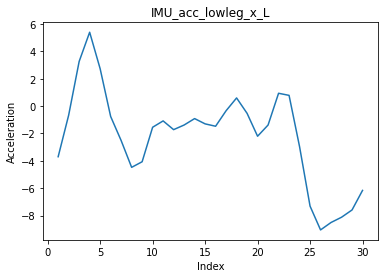

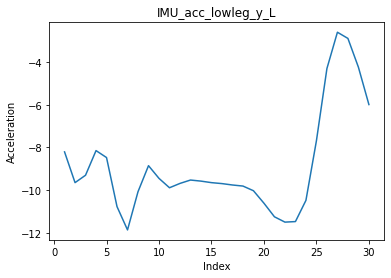

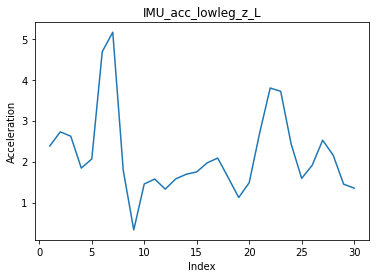

In [16]:
# plot acceleration 
import matplotlib.pyplot as plt
xticks = np.arange(1,31)
plt.plot(xticks,raw_data_array.loc[0,accel_x_labels])
plt.title(accel_x_labels[0][0:-2])
plt.ylabel('Acceleration')
plt.xlabel('Index')
plt.show()

plt.plot(xticks,raw_data_array.loc[0,accel_y_labels])
plt.title(accel_y_labels[0][0:-2])
plt.ylabel('Acceleration')
plt.xlabel('Index')
plt.show()

plt.plot(xticks,raw_data_array.loc[0,accel_z_labels])
plt.title(accel_z_labels[0][0:-2])
plt.ylabel('Acceleration')
plt.xlabel('Index')
plt.show()

In [17]:
# load raw wearable timeseries dataset 

path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning S22/24789 EE Project/Datasets - (Do Not Edit)/Slade/Wearable sensor set/test_datasets/raw_wearable_timeseries/raw_wearable_ts/'
subjects = ['S01', 'S03', 'S04', 'S05', 'S07', 'S08', 'S09', 'S10', 'S12', 'S13', 'S14']
conditions = ['C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'C11', 'C12']
raw_data_array = None

def load_wearable_processed_data(path, subjects,conditions):
  s = 1 #len(subjects)
  c = 1 #len(conditions)
  #load column labels
  features_file = path + '_dataset_specifics/features.csv'
  features_array = pd.read_csv(features_file, nrows =0)
  feat_names = list(features_array.columns[0:-5])

  for i in range(0,s):
    for j in range(c):
        filename = subjects[i] + conditions[j]
        raw_data_array = pd.read_csv(path + filename + '/' + 'x.csv', names = feat_names, index_col=False)
  return raw_data_array, full_feat_names


In [18]:
raw_data_array = None
raw_data_array, full_feat_names = load_wearable_processed_data(path, subjects, conditions)

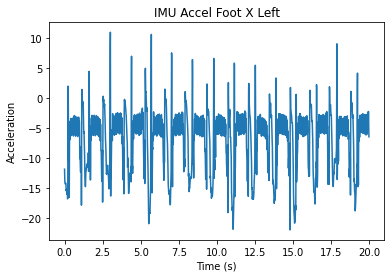

In [19]:
# plot raw timeseries data
data_to_plot = raw_data_array.loc[:,'IMU_acc_foot_x_L']
xtime = (1/100)*np.arange(0,2000)
plt.plot(xtime,data_to_plot[0:2000])
plt.ylabel('Acceleration')
plt.xlabel('Time (s)')
plt.title('IMU Accel Foot X Left')
plt.show()

In [20]:
# load validation dataset 

path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning S22/24789 EE Project/Datasets - (Do Not Edit)/Slade/Real-time testing/real_time_validation_dataset/'
subjects = ['S01', 'S02','S03', 'S04', 'S05', 'S07', 'S08', 'S09', 'S10', 'S12', 'S13', 'S14', 'S15']
conditions = ['C01','C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09']

def load_RT_validation_data(path, subjects,conditions):
  s = 1 #len(subjects)
  c = 1 #len(conditions)
  
  # print(full_feat_names)
  for i in range(0,s):
    for j in range(c):
        i = 0
        j =5
        filename = subjects[i] + '/' + conditions[j]
        gen_files = os.listdir(path + filename)
        num_files = len(gen_files)
        npy_files = []
        for i in range(num_files-2):
          temp = 'file' + str(i+1) + '.npy'
          npy_files.append(temp)
        
        test_npy_file = np.load(path + filename + '/' + npy_files[3])
        print(test_npy_file[0,:])
        print(np.shape(test_npy_file))
        # raw_data_array = pd.read_csv(path + filename + '/' + 'x.csv', names = full_feat_names, index_col=False)
  return npy_files, test_npy_file
  # return raw_data_array, full_feat_names


In [21]:
npy_files, test_file = load_RT_validation_data(path,subjects,conditions)
# print(npy_files)

[  1.425       10.925        3.978125     7.778125    -2.790625
 -19.178125     2.0367706    9.31286556   2.91876501   0.2818745
   8.78644459   0.90017986   0.        ]
(500, 13)


In [12]:
# for saved IMU data, make it into the same format as the real-time estimates
def computeEstimatesFromIMU(real_time_est, subj, cond, timezone, estimate_file_name, mass, height, shift_ind, stride_detect_window, detect_window, peak_height_thresh, peak_min_dist, shank_gyro_z_ind, b, a, deg2rad, model_weights, basal_rate, file_len_in_s = 5.0, save_gait_data=False, met_val = 0.0, overwrite = False):
    subj_cond_dir = real_time_est + subj + '/' + cond + '/'
    basal_rate = round(float(basal_rate), 3)
    data_files = os.listdir(subj_cond_dir)
    data_files = natsorted(data_files)
    print(data_files)
    sample_data = np.array([])
    with open(subj_cond_dir+data_files[-1], 'r') as f:
        reader = csv.reader(f, delimiter=',')
        for col in reader:
            timeSeries = datetime.datetime.strptime(col[0],"%d/%m/%Y %H:%M:%S")
            print(timeSeries)
            break
        for row in reader:
            init_ts = datetime.datetime.strptime(row[0],"%d/%m/%Y %H:%M:%S") #timestamps from file_timestamp.csv
            break
    f.close()
    init_ts = timezone.localize(init_ts)
    print(init_ts)
    for l, file in enumerate(data_files[:-1]):
        if (file == estimate_file_name) or (file[0:2] == 'TV'): # skip this file
            continue
        else:
            try:
                file_data = np.load(subj_cond_dir+file)
                if len(sample_data) == 0:
                    sample_data = file_data
                else:
                    sample_data = np.concatenate((sample_data, file_data), axis=0)
            except:
                pass
    print(np.shape(sample_data))
    gait_cycles,_,time_of_gait = simRealStrikes(sample_data[:,:-1], mass, height, shift_ind, stride_detect_window, detect_window, peak_height_thresh, peak_min_dist, shank_gyro_z_ind, b, a, deg2rad) 
    print("Time of Gait", str(time_of_gait))
    num_gaits,_ = gait_cycles.shape
    gait_cycles = np.concatenate((np.ones((num_gaits,1)), gait_cycles), 1)
    if save_gait_data:
        save_dir = 'C:\\Users\\patty\\Desktop\\EEE\\RealTimeTesting\\results\\data\\' + subj + '\\' + cond + '\\'
        try:
            os.makedirs(save_dir)
        except:
            pass
        np.savetxt(save_dir+'x.csv', gait_cycles, delimiter=',')
        np.savetxt(save_dir+'y.csv', np.ones((num_gaits,1))*met_val, delimiter=',')
        
    estimates = np.round(np.dot(gait_cycles,model_weights),3)
    dt_stamps = [init_ts + datetime.timedelta(seconds=(i-file_len_in_s)) for i in time_of_gait]
    print(np.shape(dt_stamps))
    basal_t_thresh = 8.0
    offset_t = 1.0
    if overwrite:
        with open(subj_cond_dir+estimate_file_name,'w') as f:
            for p in range(num_gaits):
                if (p > 0) and ((dt_stamps[p]-dt_stamps[p-1]).total_seconds() >= basal_t_thresh): # large enough gap detected
                    # adding first basal point after last gait
                    f.write("{},{},{},{}".format(time_of_gait[p-1]+offset_t, dt_stamps[p-1] + datetime.timedelta(seconds=offset_t), basal_rate, basal_rate))
                    f.write("\n")                
                    f.write("{},{},{},{}".format(time_of_gait[p]-offset_t, dt_stamps[p]- datetime.timedelta(seconds=offset_t), basal_rate, basal_rate))
                    f.write("\n")
                if estimates[p] < basal_rate:
                    f.write("{},{},{},{}".format(time_of_gait[p], dt_stamps[p], basal_rate, basal_rate))
                else:
                    f.write("{},{},{},{}".format(time_of_gait[p], dt_stamps[p], estimates[p], estimates[p]))
                f.write("\n")
        f.close()   
    return sample_data, time_of_gait, dt_stamps

In [14]:
subj = 'S02'
cond = 'C03'
sample_data, time_of_gait, dt_stamps = computeEstimatesFromIMU(real_time_est, subj, cond, timezone, estimate_file_name, masses[1], heights[1], shift_ind, stride_detect_window, detect_window, peak_height_thresh, peak_min_dist, shank_gyro_z_ind, b, a, deg2rad, model_weights, basal_rate, file_len_in_s = 5.0, save_gait_data=False, met_val = 0.0, overwrite = False)


['energy_exp_estimates.csv', 'file1.npy', 'file2.npy', 'file3.npy', 'file4.npy', 'file5.npy', 'file6.npy', 'file7.npy', 'file8.npy', 'file9.npy', 'file10.npy', 'file11.npy', 'file12.npy', 'file13.npy', 'file14.npy', 'file15.npy', 'file16.npy', 'file17.npy', 'file18.npy', 'file19.npy', 'file20.npy', 'file21.npy', 'file22.npy', 'file23.npy', 'file24.npy', 'file25.npy', 'file26.npy', 'file27.npy', 'file28.npy', 'file29.npy', 'file30.npy', 'file31.npy', 'file32.npy', 'file33.npy', 'file34.npy', 'file35.npy', 'file36.npy', 'file37.npy', 'file38.npy', 'file39.npy', 'file40.npy', 'file41.npy', 'file42.npy', 'file43.npy', 'file44.npy', 'file45.npy', 'file46.npy', 'file47.npy', 'file48.npy', 'file49.npy', 'file50.npy', 'file51.npy', 'file52.npy', 'file53.npy', 'file54.npy', 'file55.npy', 'file56.npy', 'file57.npy', 'file58.npy', 'file59.npy', 'file60.npy', 'file61.npy', 'file62.npy', 'file63.npy', 'file64.npy', 'file65.npy', 'file66.npy', 'file67.npy', 'file68.npy', 'file69.npy', 'file70.npy', 

In [16]:
print(np.shape(dt_stamps))
print(np.shape(time_of_gait))

(348,)
(348,)


In [ ]:
print(subjs)
print(masses)
print(heights)
print(basal_rate)

['S01' 'S03' 'S04' 'S05' 'S07' 'S08' 'S09' 'S10' 'S12' 'S13' 'S14']
[53.5 69.6 59.4 62.6 63.5 87.1 59.0 79.3 74.0 55.3 61.0]
[1.69 1.76 1.63 1.73 1.73 1.83 1.66 1.79 1.79 1.63 1.68]
[ 88.58732828 108.68574055 124.57806417 106.72267158 105.57897052
  95.78069581 105.835023   109.5904593  109.84651177 136.30526752
  85.55566698 108.73695105 120.89090853 122.97346866 125.2438006
  92.84462743 114.04577236 108.78816154  86.98956084 121.43715381
  93.28845172 110.2732659   92.89583793 133.72767261]


In [ ]:
# loading from results file

resPath = '/content/drive/MyDrive/Colab Notebooks/Deep Learning S22/24789 EE Project/Datasets - (Do Not Edit)/Slade/Real-time testing/results/full_results/'
basal_rate_list = np.load(resPath + 'basal_rate_list.npy')
met_real = np.load(resPath + 'met_real.npy')
print(np.shape(met_real))

(24, 8)
